### python version

In [1]:
import sys
print(sys.version)

3.7.3 (default, Jul 25 2020, 13:03:44) 
[GCC 8.3.0]


### load modules

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import matplotlib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,CSVLogger
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy,binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### module versions : -

In [3]:
print('{:<15} {}'.format('NumPy',np.__version__))
print('{:<15} {}'.format('Matplotlib',matplotlib.__version__))
print('{:<15} {}'.format('Sklearn',sklearn.__version__))
print('{:<15} {}'.format('NumPy',np.__version__))
print('{:<15} {}'.format('Tensorflow',tf.__version__))
print('{:<15} {}'.format('Keras',keras.__version__))

NumPy           1.18.5
Matplotlib      3.3.1
Sklearn         0.23.2
NumPy           1.18.5
Tensorflow      2.3.1
Keras           2.4.0


### Data visualisation

In [4]:
train_path = '/home/sudhakar/Jupyter Projects/dogs-vs-cats/dogs-vs-cats/train/'
test_path = '/home/sudhakar/Jupyter Projects/dogs-vs-cats/dogs-vs-cats/test1/'

In [20]:
def showSomeData(path):
    plt.figure(figsize=(10,5))
    filenames = os.listdir(path)
    for index,filename in enumerate(filenames[:10]):
        file_path = os.path.join(path,filename)
#         print(file_path)
        img = mpimg.imread(file_path)
        plt.subplot(2,5,index+1)
        plt.axis('off')
        plt.imshow(img)

#### training data

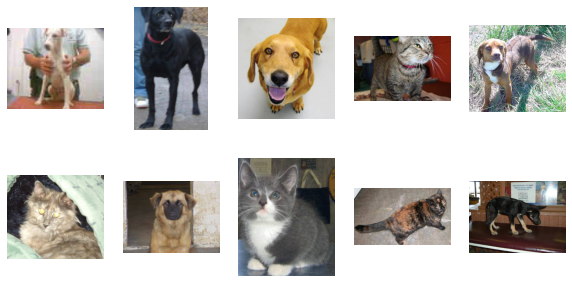

In [21]:
showSomeData(train_path)

#### test data

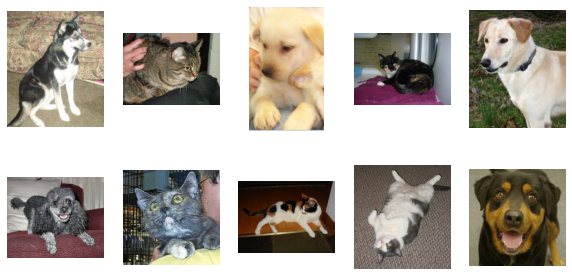

In [22]:
showSomeData(test_path)

### Preprocessing and Data Augmentation

#### prepare data

In [8]:
def createDataFrame(path):
    filenames = os.listdir(path)
    category = []
    for filename in filenames:
        if filename.startswith('cat'):
            category.append('cat')
        else:
            category.append('dog')
    
    df = pd.DataFrame({'filename':filenames , 'category':category})
    return df

In [9]:
df = createDataFrame(train_path)

In [10]:
df

,filename,category
0,dog.12322.jpg,dog
1,dog.8080.jpg,dog
2,dog.7804.jpg,dog
3,cat.6318.jpg,cat
4,dog.2125.jpg,dog
...,...,...
24995,cat.8906.jpg,cat
24996,cat.7685.jpg,cat
24997,dog.3652.jpg,dog
24998,cat.9744.jpg,cat


In [12]:
train_df , val_df = train_test_split(df , train_size=0.8 , test_size=0.2 , random_state=1 , shuffle=True)

In [13]:
train_df

,filename,category
6655,dog.8562.jpg,dog
6085,dog.5791.jpg,dog
21848,cat.10905.jpg,cat
5106,dog.135.jpg,dog
21856,dog.1313.jpg,dog
...,...,...
10955,dog.7021.jpg,dog
17289,cat.7482.jpg,cat
5192,dog.7364.jpg,dog
12172,dog.243.jpg,dog


In [14]:
val_df

,filename,category
21492,dog.11700.jpg,dog
9488,cat.3562.jpg,cat
16933,cat.1620.jpg,cat
12604,cat.993.jpg,cat
8222,dog.4985.jpg,dog
...,...,...
11139,dog.2904.jpg,dog
19053,dog.11442.jpg,dog
7037,cat.4532.jpg,cat
17119,cat.3136.jpg,cat


In [15]:
train_df['category'].nunique()

2

In [16]:
val_df['category'].nunique()

2

In [17]:
BATCH_SIZE , IMG_WIDTH , IMG_HEIGHT , CHANNELS = (32 , 256 , 256 ,3)
input_shape = (BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,CHANNELS)
input_shape

(32, 256, 256, 3)

In [18]:
train_datagen = ImageDataGenerator(
                                  rescale=1.0/255.0,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=30,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                  )

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [19]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                                 '/home/sudhakar/Jupyter Projects/dogs-vs-cats/dogs-vs-cats/train/',
                                                 x_col='filename',
                                                 y_col='category',
                                                 target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                 class_mode='binary',
                                                 batch_size=BATCH_SIZE,
                                                 seed=1)

val_batches = val_datagen.flow_from_dataframe(val_df,
                                               '/home/sudhakar/Jupyter Projects/dogs-vs-cats/dogs-vs-cats/train/',
                                               x_col='filename',
                                               y_col='category',
                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary',
                                               seed=1)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [38]:
imgs , labels = train_batches.next()

In [39]:
labels.dtype = 'i2'

In [40]:
type(labels[-1])

numpy.int16

#### some images after preprocessing

In [41]:
def plotImages(images,nrows,ncols):
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,10))
    axes = axes.flatten()
    for image,axis in zip(images,axes):
        axis.imshow(image)
        axis.axis('off')
    plt.tight_layout()
    plt.show()

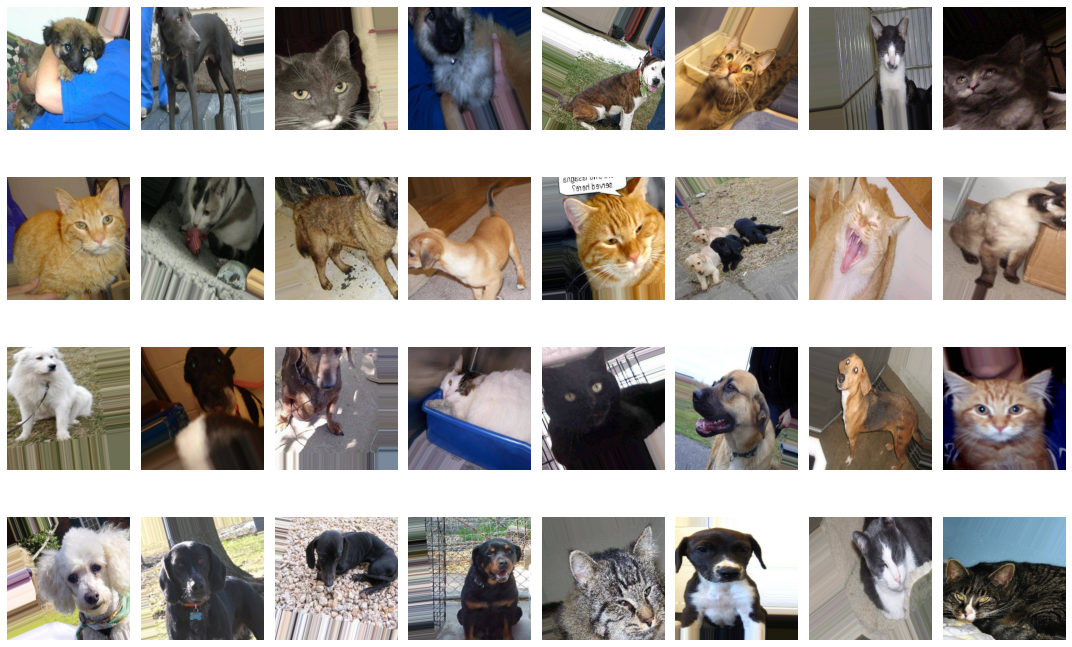

In [42]:
plotImages(imgs,nrows=4,ncols=8)

### CNN Model

#### model configuration

In [43]:
loss_function = binary_crossentropy
optimizer = Adam(learning_rate=0.001)
metrics = ['accuracy']
no_epochs = 50
no_classes = 2

In [44]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,min_lr=0.000001)

#### build the model

In [45]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_uniform',input_shape=input_shape[1:]))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_uniform'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=2,activation='softmax'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       2

In [48]:
model.compile(loss=loss_function,
             optimizer=optimizer,
             metrics=metrics)

In [49]:
history = model.fit(train_batches,
                    batch_size=BATCH_SIZE,
                    epochs=no_epochs,
                    verbose=1,
                    validation_data=val_batches,
                    callbacks=[mc])

Epoch 1/50
 10/625 [..............................] - ETA: 46:56 - loss: 7.0547 - accuracy: 0.5344

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.show()